In [ ]:
import gibbs_mcmc_nn as mc #imports the file with all the functions of the Gibbs sampler
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_tensor_type(torch.FloatTensor) 

cuda


# Introduction
In this notebook we will use the Gibbs sampler to sampel form the posterior of a neural network, in the case where the training set is MNIST.



The algorithm is described in detail in the paper **Gibbs Sampling the Posterior of Neural Networks**.




## Architecture & Posterior

We list the layers of the CNN together with their parameters.
The input in a tensor of shape $n\times 1\times28\times 28$, with $n$ the size of the training set. 
1. Convolutional layer with $4\times 4$ filter, 2 output channels, stride=2, no padding. Output: `Z`
2. Average $2\times 2$ pooling with stride=2. Output: `Z_2`
3. ReLU activation. Output `X_2`
4. Fully connected layer with $10\times 72$ weights. Output: `Z_3`
5. Argmax activation over the 10 output units. Outputs the labels



Now we must associate a posterior to this architecture. 
We do so by specifying the implicit generative process.
We assume that after each layer above  except for the argmax a Gaussian noise with variance $\Delta$ is added. The prior is i.i.d. Gaussian with inverse variances on each weight $\lambda_W^{(1)}=16,\lambda_b^{(1)}=16,\lambda_{W}^{(2)}=72,\lambda_{b}^{(2)}=72$.

In [ ]:
def CNN_net(X,W,b,s_y,s_x,H_P,W_P,W_2,b_2): 
    """
    Computes the output of the CNN network on a batch of data

    X is the input tensor
    W are the weights of the convolutional layer
    b is the bias vector associated to the convolutional layer
    s_y,s_x are the strides of the convolutional layer
    H_P, W_P are the height and width of the pooling filters
    W_2,b_2 are the weights and biases of the fully connected layer
    """
    
    Z=mc.conv2d_layer(X,W,s_y,s_x)+b[None,:,None,None]
    Z_2=mc.average_pool2d(Z,H_P,W_P)
    X_2=mc.ReLU(Z_2).reshape([Z_2.shape[0],-1])
    Z_3=X_2@(W_2.T)+b_2[None,:]
    return torch.argmax(Z_3,axis=1).type(torch.long)

## Dataset loading
We load the MNIST dataset from the file `mnist.npz` downloadable at https://www.kaggle.com/datasets/vikramtiwari/mnist-numpy .


In [ ]:
n=2000 #number of training points
n_test=5000 #number of test points
file_mnist=np.load("./mnist.npz",allow_pickle=True)
X_train=torch.tensor(file_mnist['x_train'],dtype=torch.float)[:n,None,:,:]
X_test=torch.tensor(file_mnist['x_test'],dtype=torch.float)[:n_test,None,:,:]
y_train=torch.tensor(file_mnist['y_train']).type(torch.long).flatten()[:n]
y_test=torch.tensor(file_mnist['y_test']).type(torch.long).flatten()[:n_test]


#normalizing training and test inputs
X_train=X_train[:n]/255
X_test=X_test[:n_test]/255
mean_X=torch.mean(X_train)
std_X=torch.std(X_train)
X_train=(X_train-mean_X)/std_X
X_test=(X_test-mean_X)/std_X

## Gibbs parameters

We will now run the Gibbs sampler on the dataset. 
First we must set the algorithm's parameters, i.e., $\Delta,\lambda_W^{(1)},\lambda_W^{(1)},\lambda_W^{(2)}, \lambda_b^{(2)}$. 

In [ ]:
sigma=torch.nn.ReLU()
C_X=1 #number of input channels (1 for MNIST)
H_X=28 #input height
W_X=28 #input width
H_W=4 #convolutional filter's height
W_W=4 #convolutional filter's height
C_Z=2 #number of output channels of the convolutional layer
s_y=2 #vertical stride of convolutional layer
s_x=1 #horizontal stride of convolutional layer
H_P=2 #height of the pooling filter
W_P=2 #width of the pooling filter
C=10 #number of classes
H_Z=torch.div((H_X-H_W),s_y,rounding_mode='floor')+1 
W_Z=torch.div((W_X-W_W),s_x,rounding_mode='floor')+1
H_Z_2=torch.div(H_Z,H_P,rounding_mode='floor')
W_Z_2=torch.div(W_Z,W_P,rounding_mode='floor')
d_X_2=torch.tensor(C_Z*H_Z_2*W_Z_2)
lambda_W=torch.tensor(H_W*W_W*C_X) #16
lambda_b=torch.tensor(H_W*W_W*C_X) #16
lambda_W_2=torch.tensor(d_X_2) #72
lambda_b_2=d_X_2 #72
Delta=torch.tensor(20) #temperature of the posterior

<ipython-input-5-b0086992f58e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_X_2=torch.tensor(C_Z*H_Z_2*W_Z_2)
<ipython-input-5-b0086992f58e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda_W_2=torch.tensor(d_X_2) #72


## Initialization
for the Gibbs sampler we set all variables initially to zero.


In [ ]:
#zero initialization
W=torch.zeros(size=[C_Z,C_X,H_W,W_W])
b=torch.zeros(size=[C_Z])
Z=torch.zeros(size=[n,C_Z,H_Z,W_Z])
Z_2=torch.zeros(size=[n,C_Z,H_Z//2,W_Z//2])
X_2=torch.zeros(size=[n,d_X_2])
W_2=torch.zeros(size=[C,d_X_2])
b_2=torch.zeros(size=[C])
Z_3=torch.zeros(size=[n,C])

In [ ]:
#precomute quantities for sampling the first layer's weights
#precomputed quantities
jump_y,jump_x=X_train.stride()[-2:] #number of positions I have to move in memory to go to the next  3rd, 4th index respectively in X_l.
X_strided_shape=(n,C_X,H_W,W_W,H_Z,W_Z) 
X_strides=X_train.stride()+(s_y*jump_y,s_x*jump_x)

X_strided=torch.as_strided(X_train.type(torch.float64),size=X_strided_shape, stride=X_strides)
A_tilde_resc=torch.tensordot(X_strided,X_strided, [[0,4,5],[0,4,5]])

A_resc=A_tilde_resc.reshape([C_X*H_W*W_W,C_X*H_W*W_W]) 
A_resc=A_resc+lambda_W*Delta*torch.eye(C_X*H_W*W_W,dtype=torch.float64)
Cov_W_resc=torch.linalg.inv(A_resc)  
Cholesky_Cov_W_resc=torch.linalg.cholesky(Cov_W_resc).type(torch.float32)  #<---should be passed as argument
Cov_W_resc_XT=torch.tensordot(Cov_W_resc.reshape([C_X*H_W*W_W,C_X,H_W,W_W]),X_strided,[[1,2,3],[1,2,3]]).type(torch.float32) #<--- should be passed as argument

In [ ]:
#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W=lambda_W.to(device)
lambda_b=lambda_b.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W=W.to(device)
b=b.to(device)
Z=Z.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
Z_3=Z_3.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
Cholesky_Cov_W_resc=Cholesky_Cov_W_resc.to(device)
Cov_W_resc_XT=Cov_W_resc_XT.to(device)
if(str(device)=='cuda'):
    torch.set_default_tensor_type(torch.cuda.FloatTensor) 

In [ ]:
#stuff to track during the dynamics
test_loss=[]
train_loss=[]
W_1_norm=[]
W_2_norm=[]
tmax=5000

## Run the Gibbs sampler

In [ ]:
for t in range(tmax):
    y_pred_test=CNN_net(X_test,W,b,s_y,s_x,H_P,W_P,W_2,b_2)
    y_pred_train=CNN_net(X_train,W,b,s_y,s_x,H_P,W_P,W_2,b_2)
    test_loss.append(1.-torch.sum(y_pred_test==y_test).item()/(y_test.shape[0]))
    train_loss.append(1.-torch.sum(y_pred_train==y_train).item()/(y_train.shape[0]))

    #updating the variables (in this case in reverse order)
    Z_3=mc.sample_Z_Lp1_multinomial_probit(X_2@(W_2.T)+b_2[None,:],Z_3,y_train,Delta_Z_Lp1=Delta,precise=True)
    W_2=mc.sample_W_l_fcl(X_2,b_2,Z_3,lambda_W_2,Delta_Z_lp1=Delta)
    b_2=mc.sample_b_l_fcl(W_2,Z_3,X_2,Delta_Z_lp1=Delta,lambda_b_l=lambda_b_2)
    X_2=mc.sample_X_l_fcl(mc.ReLU(Z_2).reshape([n,-1]),W_2,b_2,Z_3,Delta_X_l=Delta,Delta_Z_lp1=Delta)
    Z_2=mc.sample_Z_lp1_relu(fwd_X_l=mc.average_pool2d(Z,H_P,W_P),X_lp1=X_2.reshape([n,C_Z,H_Z_2,W_Z_2]),Delta_Z_lp1=Delta,Delta_X_lp1=Delta,precise=True)    
    Z=mc.sample_X_l_avg_pooling(fwd_Z_l=mc.conv2d_layer(X_train,W,s_y,s_x)+b[None,:,None,None],X_lp1=Z_2,Delta_X_l=Delta, Delta_X_lp1=Delta)
    W=mc.sample_W_1_conv2d(Cholesky_Cov_W_resc, Cov_W_resc_XT,b,Z,Delta_Z_2=Delta, H_W=H_W, W_W=W_W, C_1=C_X)
    b=mc.sample_b_l_conv2d(X_train,Z,W,Delta_Z_lp1=Delta,lambda_b_l=lambda_b,stride_y=s_y,stride_x=s_x)

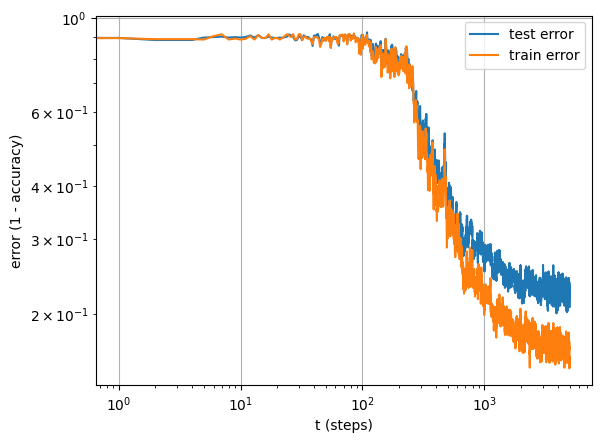

In [ ]:
plt.plot(test_loss,label="test error")
plt.plot(train_loss,label="train error")
plt.xlabel("t (steps)")
plt.ylabel("error (1 - accuracy)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()